In [19]:
import re
import os
from bidict import bidict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support, precision_score, make_scorer, recall_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import DecisionBoundaryDisplay

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
data_path = "./data/crcns/aa2/"
stims_path = os.path.join(data_path, "all_stims")
cells_path = os.path.join(data_path, "all_cells")

brain_area_mapping = {
    'OV': 'nucleus ovoidalis',
    'L3': 'Primary Forebrain (L3)',
    'mld': 'mesencephalicus lateralis dorsalis',
    'CM': 'Caudal Mesopallium',
    'None': 'None',
    'L2a': 'Primary Forebrain (L2a)',
    'L': 'Primary Forebrain (L)',
    'L1': 'Primary Forebrain (L1)',
    'L2b': 'Primary Forebrain (L2b)',
}

def listdir(path):
    return [x for x in os.listdir(path) if not x.startswith(".")]

def get_region(regions_df, cell_id):
    regions = regions_df[regions_df.index == cell_id]["region"].values
    assert len(regions) == 1, f"Unexpected number of regions: {len(regions)}"
    return brain_area_mapping[regions[0]]

def get_main_df():
    d = {"bird": [], "cell_id": [], "group_index": [], "trial_index": [], "nb_trials": [], "brain_region": [], "stimulus_type": [], "stimulus_file": [], "spike_file": [], "average_spikes": []}

    cell_regions_df = pd.read_csv(os.path.join(data_path, "cell_regions.csv"), header=None, index_col=0)
    cell_regions_df.columns = ["region"]
    cell_regions_df.index.name = "Cell ID"

    cells = listdir(cells_path)
    for cell in cells:
        stim_types = listdir(os.path.join(cells_path, cell))
        for stim_type in stim_types:
            cell_stimuli_paths = []
            spike_paths = []

            stim_files = listdir(os.path.join(cells_path, cell, stim_type))
            for stim_file in stim_files:
                if stim_file.startswith("spike"):
                    spike_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                elif stim_file.startswith("stim"):
                    cell_stimuli_paths.append(os.path.join(cells_path, cell, stim_type, stim_file))
                else:
                    assert False, f"Unexpected file prefix: {stim_file}"

            spike_paths.sort()
            cell_stimuli_paths.sort()

            for spike_path, stim_path in zip(spike_paths, cell_stimuli_paths):
                stim_index = int(re.findall(r"\d+", stim_path)[-1])
                spike_index = int(re.findall(r"\d+", spike_path)[-1])

                if spike_index != stim_index:
                    continue

                with open(stim_path, "r") as f:
                    stim_file_path = os.path.join(stims_path, f.read().strip())

                with open(spike_path, "r") as f:
                    spike_trials = f.read().splitlines()

                lens = []
                for trial in spike_trials:
                    trial_spikes = 0
                    for spike in trial.split():
                        if spike != "" and float(spike) >= 0:
                            trial_spikes += 1

                    lens.append(trial_spikes)

                bird, cell_id = cell.split("_", 1)
                if "_" in cell_id:
                    cell_id, group_index = cell_id.split("_")
                else:
                    group_index = 'A'

                d["cell_id"].append(cell_id)
                d["trial_index"].append(stim_index)
                d["group_index"].append(group_index)
                d["bird"].append(bird)
                d["nb_trials"].append(len(spike_trials))
                d["brain_region"].append(get_region(cell_regions_df, cell))
                d["stimulus_type"].append(stim_type)
                d["average_spikes"].append(np.average(lens))
                d["stimulus_file"].append(stim_file_path)
                d["spike_file"].append(spike_path)

    return pd.DataFrame(d)

df = get_main_df()

In [23]:
df.stimulus_type.unique()

array(['flatrip', 'conspecific', 'songrip'], dtype=object)

In [24]:
df = df[df.brain_region != "None"]

In [25]:
l = list(df.groupby(["bird", "group_index", "trial_index", "stimulus_type"]))
probs = []

for x, y in l:
    # assert y.brain_region.nunique() == len(y), y
    try:
        assert y.stimulus_type.nunique() == 1
        assert y.nb_trials.nunique() == 1
    except:
       probs.append(x) 

ndf = df.copy()

for bird, group_index, trial_index, stimulus_type in probs:
    ndf = ndf[(ndf.bird != bird) | (ndf.group_index != group_index) | (ndf.trial_index != trial_index) | (ndf.stimulus_type != stimulus_type)]

In [26]:
def plot_entry(index):
    entry = df.iloc[index]
    with open(entry['Spike File'], 'r') as f:
        times = [float(y) for x in [f.read().split('\n')[0]] for y in x.split()]

    print(entry['Spike File'])

    # Plot the spikes
    plt.vlines(times, 0, 1, color='black')
    
    plt.show()

In [27]:
DIVISOR = 70

In [28]:
max_times = []
for i in range(len(df)):
    with open(df.iloc[i].spike_file, "r") as f:
        max_times.append(max([float(y) for x in f.read().split('\n') for y in x.split()]))

max_time = int((max(max_times)) / DIVISOR) + 1

In [29]:
cell_ids = bidict({cell_id: i for i, cell_id in enumerate(set(df.index))})
brain_regions = bidict({region: i for i, region in enumerate(set(df.brain_region))})
stimulus_types = bidict({stimulus: i for i, stimulus in enumerate(set(df.stimulus_type))})

In [30]:
from tqdm import tqdm
from collections import defaultdict

# d = {"Brain Region": []}
d = {f"{y}_{x}": [] for y in brain_regions for x in range(max_time)}
y = []

for (bird, group_index, trial_index, stimulus_type), group in tqdm(l):
    nb_trials = group.iloc[0].nb_trials

    files = []
    for path, region in zip(group.spike_file, group.brain_region):
        files.append((open(path, "r"), region))

    for x in range(nb_trials):
        spikes = defaultdict(int)
        for f, region in files:
            for spike in f.readline().split():
                spike = int(float(spike) / DIVISOR)

                if spike >= 0 and spike <= max_time:
                    spikes[f"{region}_{spike}"] += 1
                
        for time in range(max_time):
            regions = set(group.brain_region.values)
            for region in brain_regions:
                if region in regions:
                    d[f"{region}_{time}"].append(spikes[f"{region}_{time}"] + 1)
                else:
                    d[f"{region}_{time}"].append(0)

        y.append(stimulus_types[stimulus_type])

                

    

    # with open(spike_file, "r") as f:
    #     trials = f.readlines()
    #     for trial in trials:
    #         d["Cell ID"].append(cell_ids[cell_id])
    #         d["Brain Region"].append(brain_regions[brain_region])
    #         d["Number of Spikes"].append(len(trial.split()))
    #         y.append(1 if stimulus_type == "conspecific" else 0)

    #         times = {int(float(time)) for time in trial.split()}
    #         for time in range(max_time):
    #             if time in times:
    #                 d[str(time)].append(1)
    #             else:
    #                 d[str(time)].append(0)

    for file, _ in files:
        file.close()
        
X = pd.DataFrame(d)

X_backup = X.copy()
y_backup = y.copy()

100%|██████████| 4049/4049 [00:13<00:00, 306.49it/s]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train, y_train)
print(round(LR.score(X_test,y_test), 4))

0.6691


In [ ]:
for key in brain_regions.keys():
    print(key)

In [ ]:
brain_region_of_interest = "nucleus ovoidalis"
filteredX = X[X["Brain Region"] == brain_regions[brain_region_of_interest]]
filteredy = np.array(y)[X["Brain Region"] == brain_regions[brain_region_of_interest]]

In [ ]:
import random

# We have more 1s than 0s, make the numbers equal
indices = random.sample(np.argwhere(filteredy == 1).flatten().tolist(), len(np.argwhere(filteredy == 0).flatten().tolist()))
indices += np.argwhere(filteredy == 0).flatten().tolist()

filteredy = filteredy[indices]
filteredX = filteredX.iloc[indices]

In [ ]:
len(filteredy[filteredy == 0])

In [ ]:
# brain_region_of_interest = "nucleus ovoidalis"

# filteredX = X[X["Brain Region"] == brain_regions[brain_region_of_interest]]
# filteredy = np.array(y)[X["Brain Region"] == brain_regions[brain_region_of_interest]]


X_train, X_test, y_train, y_test = train_test_split(filteredX, filteredy, test_size=0.2, random_state=42)

LR = LogisticRegression(random_state=0, solver="lbfgs", multi_class='multinomial').fit(X_train, y_train)
print(round(LR.score(X_test,y_test), 4))

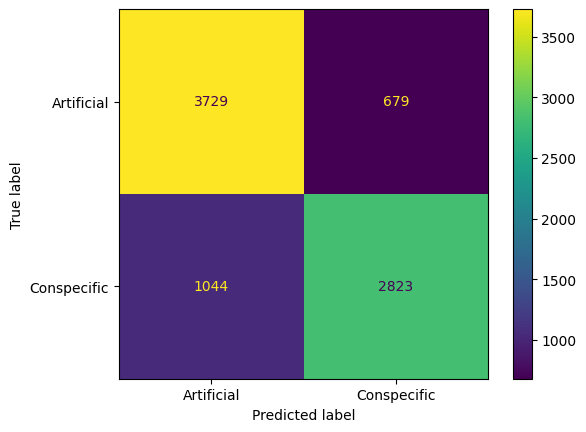

In [105]:
predictions = LR.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artificial", "Conspecific"])
disp.plot()

In [ ]:
from sklearn.linear_model import LogisticRegression

for cell_id in cell_ids.keys():
    filteredX = X[X["Cell ID"] == cell_ids[cell_id]]
    filteredy = np.array(y)[X["Cell ID"] == cell_ids[cell_id]]
    X_train, X_test, y_train, y_test = train_test_split(filteredX, filteredy, test_size=0.2, random_state=42)

    LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
    print(f"{cell_id}: {round(LR.score(X_test,y_test), 4)}")

    

In [16]:
from sklearn.ensemble import RandomForestClassifier

# RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
# RF.fit(X, y)
# round(RF.score(X,y), 4)

In [17]:
from sklearn.neural_network import MLPClassifier

# NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
# NN.fit(X, y)
# round(NN.score(X,y), 4)

In [16]:
from sklearn.neural_network import MLPClassifier

# 0.8724
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(300, 150, 10), random_state=1).fit(X_train, y_train)
round(NN.score(X_test, y_test), 4)

0.7705

In [49]:
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 150, 50), random_state=1).fit(X_train, y_train)
round(NN.score(X_test, y_test), 4)

0.8595

In [35]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
print(round(LR.score(X_test,y_test), 4))

SVM = SVC(decision_function_shape="ovo").fit(X_train, y_train)
print(round(SVM.score(X_test, y_test), 4))

RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0).fit(X_train, y_train)
print(round(RF.score(X_test, y_test), 4))

0.7964


In [ ]:
def evaluate_model(clf, X, y, ftrs=None):
    fig, axes = plt.subplots(1,2,figsize=(13,5))
    predictions = clf.predict(X)
    cm = confusion_matrix(y, predictions, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=axes[0])
    print(classification_report(y, predictions, zero_division=1))

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)

In [ ]:
max_times = []
for i in range(len(df)):
    with open(df.iloc[i]["Spike File"], "r") as f:
        max_times.append(max([float(y) for x in f.read().split('\n') for y in x.split()]))

max_time = int(max(max_times)) + 1

d = {"Cell ID": [], "Brain Region": []}
d.update({str(x): [] for x in range(max_time)})
y = []

for i in range(len(df)):
    cell_id = df.index[i]
    brain_region = df.iloc[i]["Brain Region"]
    stimulus_type = df.iloc[i]["Stimulus Type"]

    with open(df.iloc[i]["Spike File"], "r") as f:
        trials = f.readlines()
        for trial in trials:
            d["Cell ID"].append(cell_ids[cell_id])
            d["Brain Region"].append(brain_regions[brain_region])
            y.append(stimulus_types[stimulus_type])

            times = {int(float(time)) for time in trial.split()}
            for time in range(max_time):
                if time in times:
                    d[str(time)].append(1)
                else:
                    d[str(time)].append(0)
        
X = pd.DataFrame(d)

# X_backup = X.copy()
# y_backup = y.copy()

In [ ]:
d = {"Cell ID": [], "Brain Region": [], "Average Spikes": []}
avgy = []

for i in range(len(df)):
    cell_id = df.index[i]
    brain_region = df.iloc[i]["Brain Region"]
    stimulus_type = df.iloc[i]["Stimulus Type"]

    d["Cell ID"].append(cell_ids[cell_id])
    d["Brain Region"].append(brain_regions[brain_region])
    d["Average Spikes"].append(df.iloc[i]["Average Spikes"])
    avgy.append(stimulus_types[stimulus_type])

avgX = pd.DataFrame(d)

In [ ]:
for brain_region_of_interest in brain_regions.keys():
    filteredX = avgX[avgX["Brain Region"] == brain_regions[brain_region_of_interest]]
    filteredy = np.array(avgy)[avgX["Brain Region"] == brain_regions[brain_region_of_interest]]


    X_train, X_test, y_train, y_test = train_test_split(filteredX, filteredy, test_size=0.2, random_state=42)
    LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
    print(f"{brain_region_of_interest}: {round(LR.score(X_test,y_test), 4)}")

In [ ]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
print(round(LR.score(X_test,y_test), 4))

In [ ]:
brain_region_of_interest = "nucleus ovoidalis"
filteredX = avgX[avgX["Brain Region"] == brain_regions[brain_region_of_interest]]
filteredy = np.array(avgy)[avgX["Brain Region"] == brain_regions[brain_region_of_interest]]


X_train, X_test, y_train, y_test = train_test_split(filteredX, filteredy, test_size=0.2, random_state=42)

In [50]:
# LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
# print(round(LR.score(X_test,y_test), 4))

# SVM = SVC(decision_function_shape="ovo").fit(X_train, y_train)
# print(round(SVM.score(X_test, y_test), 4))

RF = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0).fit(X_train, y_train)
print(round(RF.score(X_test, y_test), 4))

# NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(1000, 1000, 150, 50, 50, 50, 10), random_state=1).fit(X_train, y_train)
# round(NN.score(X_test, y_test), 4)

0.7623


In [ ]:
df.to_csv("/tmp/shite.csv")

In [ ]:
# Where cell id startswith gr
df[df.index.str.startswith("gr")]

In [ ]:
s = "oo0108_1_A"
s.split("_", 1)